In [1]:
# %%
import ot
import numpy as np
import otmol as otm
import pandas as pd
from openbabel import pybel
import time
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import os
from utils import *
# %matplotlib widget

In [2]:
def Experiment(mol_pair, 
               data_path: str = None
               ):
    """
    Experiment with ArbAlign data.
    """
    results = []
    # Load the molecule pairs from the specified file
    for nameA, nameB in mol_pair:
        start_time = time.time()
        X_A = parse_and_permute_xyz(os.path.join(data_path, nameA)) # just reorder atoms inside each water molecule to O H H
        X_B = parse_and_permute_xyz(os.path.join(data_path, nameB)) 
        T_A, T_B = np.array(['O', 'H', 'H']*(X_A.shape[0]//3), dtype=str), np.array(['O', 'H', 'H']*(X_B.shape[0]//3), dtype=str)
        #C = cost_matrix(T_A, T_B) # this makes O to O, H to H
        OX_A, OX_B = X_A[T_A == 'O'], X_B[T_B == 'O']
        #p_best = None
        P_best = None
        alpha_best = None
        list_P = pertubrationOT(OX_A, OX_B, p = 1, n_trials = 500, scale = 0.1)
        rmsd_best = 1e10
        for perm in list_P:
            P = permutation_to_matrix(perm)
            R, t = molecule_alignment_allow_reflection2(OX_A, OX_B, P)
            X_B_aligned = (R @ X_B.T).T + t
            D_ot = np.ones((X_A.shape[0], X_B.shape[0]), dtype=float)*1e6
            for i in range(0, X_A.shape[0], 3): 
                # this is trying to construct a distance matrix such that one water molecule is mapped to another
                # according to P, based on newly aligned X_B
                j = np.argmax(P[i//3])*3
                D_ot[i, j] = 0. # O to O
                D_ot[i+1:i+3, j+1:j+3] = distance_matrix(X_A[i+1:i+3], X_B_aligned[j+1:j+3])
            P_ot = ot.emd([], [], D_ot)
            X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P_ot)
            #R, t = molecule_alignment_allow_reflection2(X_A[T_A == 'O'], X_B[T_B == 'O'], P)
            rmsd = RMSD(X_A, X_B_aligned[np.argmax(P_ot, axis=1)])
            if rmsd < rmsd_best:
                rmsd_best = rmsd
                P_best = P_ot
        end_time = time.time()
        optimal_assignment = np.argmax(P_best, axis=1)

        if len(np.unique(optimal_assignment)) != X_A.shape[0]: # check if the assignment is 1 to 1
            print(nameA, nameB, 'Warning: the assignment is not 1 to 1')
        if not is_wc_permutation(optimal_assignment):
            print(nameA, nameB, 'Warning: the assignment is not a water cluster permutation')
        if compare_lists(T_A, T_B[optimal_assignment]): # check if atom names are matched. We have matched T_B with T_A by parse_and_permute_xyz()
            print(nameA, nameB, 'Warning: unmatched atom names exist')
        results.append({
            'nameA': nameA,
            'nameB': nameB,
            'RMSD(otmol)': rmsd_best,
            '# atoms': X_A.shape[0],
            'alpha': alpha_best,
            'time': end_time - start_time,
            'assignment': optimal_assignment,
            #'atomname_diff': compare_lists(T_A, T_B[optimal_assignment])
        }) 
        print(nameA, nameB, f"{rmsd_best:.2f}", f"{end_time - start_time:.2f}s")

    return pd.DataFrame(results)

In [7]:
data_path = "./DataArbAlign/Water-Clusters"
mol_pair_list_path = os.path.join(data_path, 'list')
_molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='water cluster')
molecule_pairs = []
for nameA, nameB in _molecule_pairs:
    molecule_pairs.append((nameA+'.xyz', nameB+'.xyz'))
otmol_res = Experiment(molecule_pairs, data_path)

2-Cs-1.xyz 2-OpenC1.xyz 0.32 0.00s
3-UUD.xyz 3-UUU.xyz 0.31 0.46s
4-Ci.xyz 4-S4.xyz 0.49 0.45s
5-CA-A.xyz 5-CA-B.xyz 0.76 0.48s
6-BAG.xyz 6-BK-1.xyz 1.04 0.47s
7-BI1.xyz 7-BI2.xyz 0.45 0.46s
8-D2d.xyz 8-S4.xyz 0.61 0.57s
9-D2dDD.xyz 9-S4DA.xyz 0.64 0.51s
10-PP1.xyz 10-PP2.xyz 0.64 0.60s
11-551A-1.xyz 11-551A-4.xyz 0.14 0.57s
12-D2d-1-L.xyz 12-D2d-1-R.xyz 0.51 0.61s
13-TIP4P.xyz 13-TIP5P.xyz 1.23 0.61s
14-1.xyz 14-2.xyz 0.55 0.63s
15-1.xyz 15-2.xyz 1.18 0.71s
16-TIP4P.xyz 16-TIP5P.xyz 1.61 0.73s
17-TIP4P.xyz 17-TIP5P.xyz 1.21 0.76s
18-TIP4P.xyz 18-TIP5P.xyz 1.50 0.80s
19-TIP4P.xyz 19-TIP5P.xyz 1.43 0.82s
20-TIP4P.xyz 20-TIP5P.xyz 1.80 0.88s
21-TIP4P.xyz 21-TIP5P.xyz 1.53 0.89s
25-1.xyz 25-2.xyz 0.96 0.92s
40-a.xyz 40-b.xyz 2.27 1.72s
60-1.xyz 60-2.xyz 2.08 2.74s
100-1.xyz 100-2.xyz 2.11 6.90s


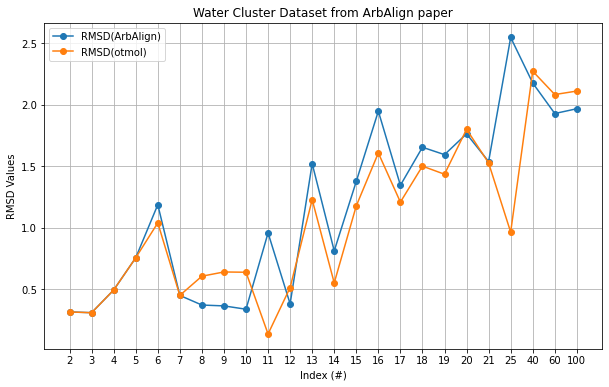

In [14]:
# Concatenate otmol_res and df along the columns
arbalign_res = pd.read_csv(os.path.join(data_path, 'rmsd-2017.dat'), sep='\s+')

combined_df = pd.concat([otmol_res, arbalign_res], axis=1).rename(columns={'RMSD(KM-ByAtomName)': 'RMSD(ArbAlign)'})

# Plot the specified columns against the uniform index
columns_to_plot = ["RMSD(ArbAlign)", "RMSD(otmol)"]

plt.figure(figsize=(10, 6))
# Plot each column against the uniform index
for column in columns_to_plot:
    plt.plot(range(len(combined_df['#'])), combined_df[column], marker='o', label=column)

# Update the x-axis ticks to show the actual values in the '#' column
plt.xticks(range(len(combined_df['#'])), combined_df['#'])

plt.title("Water Cluster Dataset from ArbAlign paper")
plt.xlabel("Index (#)")  # Reflect the '#' column in the label
plt.ylabel("RMSD Values")
plt.legend()
plt.grid(True)

In [8]:
group1_data_path = "./Our_Benchmark_20250410_ver1/Water_Cluster_3_30/water_xyz_output_1st_2nd"
#data_path = "./DataArbAlign/FGG"
group1_info = pd.read_csv('./Our_Benchmark_20250410_ver1/Water_Cluster_3_30/water_cluster_1st_2nd_lowest_energy.csv')

In [9]:
#molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='water cluster')
group1_res = Experiment(zip(group1_info['Reference'], group1_info['Target']), group1_data_path)
#print(otmol_res)

Wat_3_cluster_0_1st_lowest.xyz Wat_3_cluster_1_2nd_lowest.xyz 1.4939491208167446
Wat_4_cluster_2_1st_lowest.xyz Wat_4_cluster_3_2nd_lowest.xyz 0.9541858398950136
Wat_5_cluster_12_1st_lowest.xyz Wat_5_cluster_13_2nd_lowest.xyz 0.13331245753841256
Wat_6_cluster_31_1st_lowest.xyz Wat_6_cluster_32_2nd_lowest.xyz 0.21765242236835547
Wat_7_cluster_137_1st_lowest.xyz Wat_7_cluster_138_2nd_lowest.xyz 0.7789267889779156
Wat_8_cluster_607_1st_lowest.xyz Wat_8_cluster_608_2nd_lowest.xyz 0.6072046036937423
Wat_9_cluster_1184_1st_lowest.xyz Wat_9_cluster_1185_2nd_lowest.xyz 0.5814188223013466
Wat_10_cluster_5310_1st_lowest.xyz Wat_10_cluster_5311_2nd_lowest.xyz 0.6253297469870337
Wat_11_cluster_33413_1st_lowest.xyz Wat_11_cluster_33414_2nd_lowest.xyz 0.9101463244708897
Wat_12_cluster_43582_1st_lowest.xyz Wat_12_cluster_43583_2nd_lowest.xyz 0.5057728096816121
Wat_13_cluster_86223_1st_lowest.xyz Wat_13_cluster_86224_2nd_lowest.xyz 0.4931530923955843
Wat_14_cluster_144675_1st_lowest.xyz Wat_14_cluster

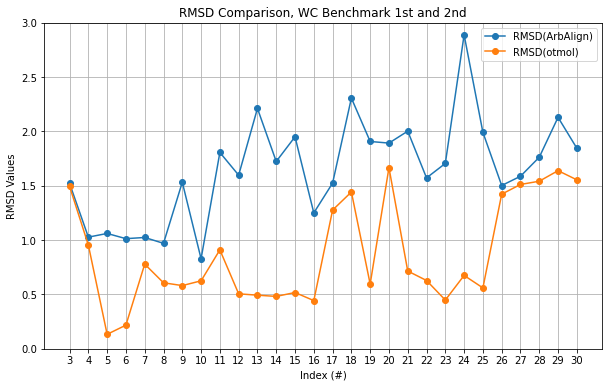

In [10]:
combined_df = pd.concat([group1_res, group1_info], axis=1).rename(columns={'Best_RMSD': 'RMSD(ArbAlign)'})
# Plot the specified columns against the uniform index
columns_to_plot = ["RMSD(ArbAlign)", "RMSD(otmol)"]

plt.figure(figsize=(10, 6))
# Plot each column against the uniform index
for column in columns_to_plot:
    plt.plot(range(len(combined_df['Wat_num'])), combined_df[column], marker='o', label=column)

# Update the x-axis ticks to show the actual values in the '#' column
plt.xticks(range(len(combined_df['Wat_num'])), combined_df['Wat_num'])
plt.title("RMSD Comparison, WC Benchmark 1st and 2nd")
plt.xlabel("Index (#)")  # Reflect the '#' column in the label
plt.ylabel("RMSD Values")
plt.ylim(0, 3)
plt.legend()
plt.grid(True)

group2

In [12]:
group2_data_path = "./Our_Benchmark_20250410_ver1/Water_Cluster_3_30/water_xyz_output_1st_to_20th"
#data_path = "./DataArbAlign/FGG"
group2_info = pd.read_csv('./Our_Benchmark_20250410_ver1/Water_Cluster_3_30/water_cluster_largest_RMSD_pair_among_20_lowest_energy.csv')
group2_res = Experiment(zip(group2_info['Reference'], group2_info['Target']), group2_data_path)

Wat_3_cluster_0_lowest_1.xyz Wat_3_cluster_1_lowest_2.xyz 1.4939491208167446
Wat_4_cluster_2_lowest_1.xyz Wat_4_cluster_10_lowest_9.xyz 1.3910981079734717
Wat_5_cluster_13_lowest_2.xyz Wat_5_cluster_22_lowest_11.xyz 0.8784156521510353
Wat_6_cluster_42_lowest_12.xyz Wat_6_cluster_50_lowest_20.xyz 0.9327911098366273
Wat_7_cluster_137_lowest_1.xyz Wat_7_cluster_147_lowest_11.xyz 0.8236841969127355
Wat_8_cluster_615_lowest_9.xyz Wat_8_cluster_616_lowest_10.xyz 0.723793894327033
Wat_9_cluster_1184_lowest_1.xyz Wat_9_cluster_1195_lowest_12.xyz 0.7711700196226298
Wat_10_cluster_5323_lowest_14.xyz Wat_10_cluster_5324_lowest_15.xyz 0.5962942136971585
Wat_11_cluster_33413_lowest_1.xyz Wat_11_cluster_33415_lowest_3.xyz 0.6234995473061073
Wat_12_cluster_43582_lowest_1.xyz Wat_12_cluster_43599_lowest_18.xyz 0.8073707985933491
Wat_13_cluster_86223_lowest_1.xyz Wat_13_cluster_86236_lowest_14.xyz 0.6889633776317423
Wat_14_cluster_144683_lowest_9.xyz Wat_14_cluster_144693_lowest_19.xyz 0.76334805762676

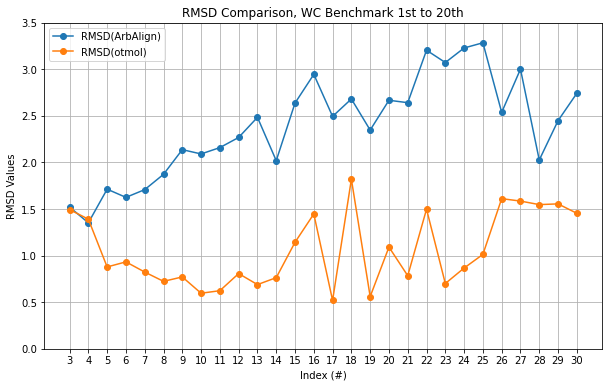

In [13]:
combined_df = pd.concat([group2_res, group2_info], axis=1).rename(columns={'Best_RMSD': 'RMSD(ArbAlign)'})
# Plot the specified columns against the uniform index
columns_to_plot = ["RMSD(ArbAlign)", "RMSD(otmol)"]

plt.figure(figsize=(10, 6))
# Plot each column against the uniform index
for column in columns_to_plot:
    plt.plot(range(len(combined_df['Wat_num'])), combined_df[column], marker='o', label=column)

# Update the x-axis ticks to show the actual values in the '#' column
plt.xticks(range(len(combined_df['Wat_num'])), combined_df['Wat_num'])
plt.title("RMSD Comparison, WC Benchmark 1st to 20th")
plt.xlabel("Index (#)")  # Reflect the '#' column in the label
plt.ylabel("RMSD Values")
plt.ylim(0, 3.5)
plt.legend()
plt.grid(True)

In [9]:
#print(distance_matrix(X_A[:6], X_A[:6]))

Some examples

0.6748282434518674
['O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H'
 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H'
 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H'
 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H']
['O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H'
 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H'
 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H'
 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H']
[]


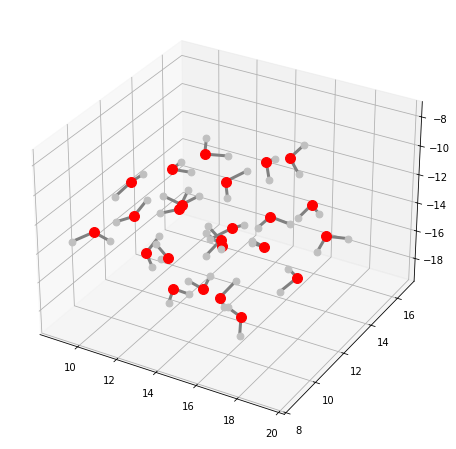

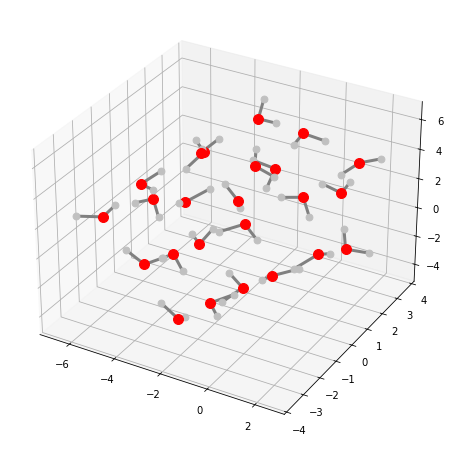

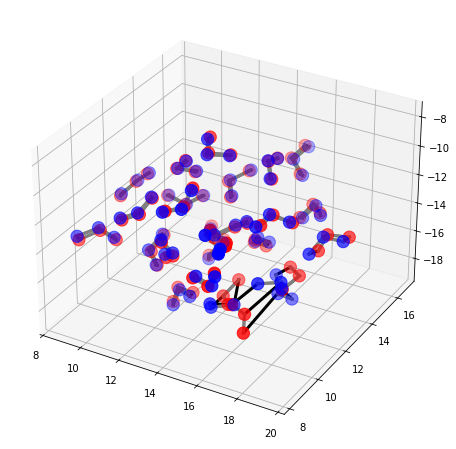

In [10]:
def permutation_to_matrix(permutation):
    """
    Converts a permutation list to a permutation matrix.
    
    Args:
        permutation (list or array): A list or array representing the permutation.
                                     For example, [2, 0, 1] means index 0 maps to 2, index 1 maps to 0, etc.
    
    Returns:
        numpy.ndarray: A permutation matrix.
    """
    n = len(permutation)
    matrix = np.zeros((n, n), dtype=int)
    for i, j in enumerate(permutation):
        matrix[i, j] = 1
    return matrix
molA = next(pybel.readfile("xyz", "./Our_Benchmark_20250410_ver1/Water_Cluster_3_30/water_xyz_output_1st_2nd/Wat_24_cluster_1928474_1st_lowest.xyz"))
molB = next(pybel.readfile("xyz", "./Our_Benchmark_20250410_ver1/Water_Cluster_3_30/water_xyz_output_1st_2nd/Wat_24_cluster_1928475_2nd_lowest.xyz"))
X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
X_B, T_B, B_B = otm.tl.process_molecule(molB)
otm.pl.plot_molecule(X_A, T_A, B_A, coloring = 'type', sizing = 'type')
otm.pl.plot_molecule(X_B, T_B, B_B, coloring = 'type', sizing = 'type')
P = permutation_to_matrix(group1_res['assignment'][21])
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P) 
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(T_A)
print(T_B[np.argmax(P, axis=1)])
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P, weight_cutoff=0.01)
plt.show()


0.13331245753841256
['O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H']
['O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H' 'O' 'H' 'H']
[]


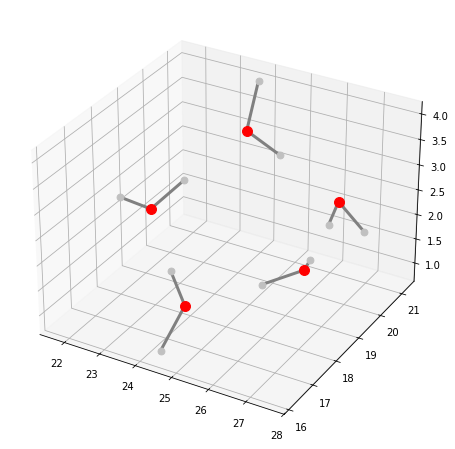

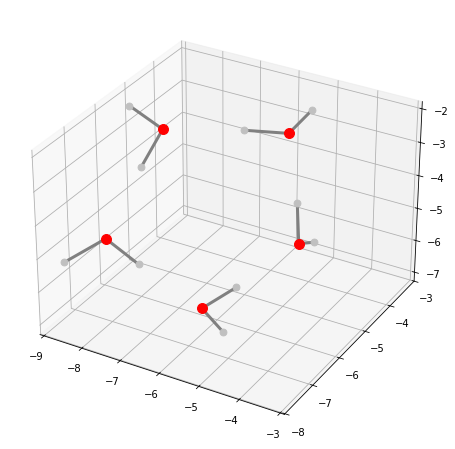

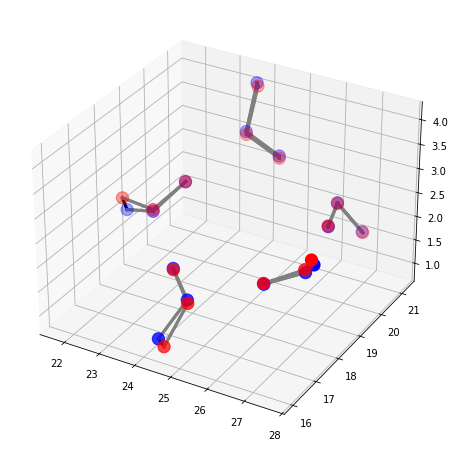

In [11]:
molA = next(pybel.readfile("xyz", "./Our_Benchmark_20250410_ver1/Water_Cluster_3_30/water_xyz_output_1st_2nd/Wat_5_cluster_12_1st_lowest.xyz"))
molB = next(pybel.readfile("xyz", "./Our_Benchmark_20250410_ver1/Water_Cluster_3_30/water_xyz_output_1st_2nd/Wat_5_cluster_13_2nd_lowest.xyz"))
X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
X_B, T_B, B_B = otm.tl.process_molecule(molB)
otm.pl.plot_molecule(X_A, T_A, B_A, coloring = 'type', sizing = 'type')
otm.pl.plot_molecule(X_B, T_B, B_B, coloring = 'type', sizing = 'type')
P = permutation_to_matrix(group1_res['assignment'][2])
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P) 
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(T_A)
print(T_B[np.argmax(P, axis=1)])
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P, weight_cutoff=0.01)
plt.show()

In [12]:
print(compare_lists(T_A, T_B[optimal_assignment]))

NameError: name 'optimal_assignment' is not defined

In [ ]:
print(D_ot[:6, :6])

[[3.86416816e+00 3.98282184e+00 3.71202235e+00 1.00000000e+06
  1.00000000e+06 1.00000000e+06]
 [3.71906134e+00 3.60905448e+00 3.67924659e+00 1.00000000e+06
  1.00000000e+06 1.00000000e+06]
 [3.37900705e+00 3.59275180e+00 3.02897484e+00 1.00000000e+06
  1.00000000e+06 1.00000000e+06]
 [1.00000000e+06 1.00000000e+06 1.00000000e+06 1.26791290e+00
  1.56296146e+00 4.75895131e-01]
 [1.00000000e+06 1.00000000e+06 1.00000000e+06 1.65910359e+00
  1.44239409e+00 1.33943188e+00]
 [1.00000000e+06 1.00000000e+06 1.00000000e+06 8.88707003e-01
  1.62721652e+00 7.07287591e-01]]
